# 1. Data tool

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import copy
from torch.autograd import Variable
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import time
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import random_split
from torch.nn.init import kaiming_uniform_
from torch.nn.utils.rnn import pad_sequence


class MyDatasetOptimized(Dataset):
    def __init__(self, data_dir, num_tail=0, transform=None,number_of_files=0,max_length=1100, dropout =0.5, model_type="train",label_set=None):
        #self.data_files = [file for file in os.listdir(data_dir) if file.startswith('traj') and file.endswith('.npy')]
        # filename rule: traj_knot{knottype}_L{length}_close.npy
        # only load the data with length <= max_length
        self.data_files = [file for file in os.listdir(data_dir) if file.startswith('traj') and file.endswith('.npy') and int(file.split('_')[2][1:])<=max_length]
        self.num_files = len(self.data_files)
        self.labels = [file.split('_')[1][4:] for file in self.data_files]
        self.num_labels = len(set(self.labels))

        self.data = []
        self.transform = transform
        self.num_tail = num_tail

        for count, data_file in enumerate(self.data_files):
            print(f"File # {count}: {data_file}")
            if(number_of_files!=0 and count>=number_of_files):
                break
            data_path = os.path.join(data_dir, data_file)
            data = np.load(data_path, allow_pickle=True)
            # drop part
            if dropout > 0:
                if model_type == "train":
                    # 如果文件名不包括random
                    if "random" not in data_file:
                        data = data[:int(len(data)*dropout)]
                else:
                    data = data[int(len(data)*dropout):]
            
            #print("first point",data[0,0,:])
            print("data shape",data.shape)

            # label corresponding to the file name
            label = data_file.split('_')[1][4:]
            if label_set is None:
                label_int = list(set(self.labels)).index(label)
            else:
                label_int = label_set.index(label)
            print("label",label_int)
            for item in data:
                item = self.preprocess_item(item)
                self.data.append((label_int, item))


    def preprocess_item(self, item):
        # recenter
        item = item - item.mean(axis=0)
        # stack bond vectors
        bond = np.concatenate((item[1:] - item[:-1], item[0:1] - item[-1:]), axis=0)
        item = np.concatenate((item, bond), axis=1)

        return item
    
    def preprocess_item_simple(self, item):
        # recenter 
        item = item - item.mean(axis=0)
        return item

    def __getitem__(self, index):
        label, item = self.data[index]
        if self.transform:
            item = self.transform(item)
        return torch.tensor(item, dtype=torch.float32), torch.tensor(label, dtype=torch.int64)

    def __len__(self):
        return len(self.data)

# Transform function example
def transform_function(item):
    # Apply any transformation like normalization, etc.
    return item

# Create DataLoader
def collate_batch(batch):
    src_batch, label_batch = [], []
    for (src_item, label) in batch:
        src_batch.append(src_item.detach().clone())
        label_batch.append(label)
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=0.0)  # 填充操作
    label_batch = torch.tensor(label_batch, dtype=torch.int64)
    return src_batch, label_batch

# Calculate accuracy
def accuracy(data_loader, model, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Usage
dataset_optimized = MyDatasetOptimized('./', num_tail=0, transform=transform_function)
input_dim = dataset_optimized[0][0].shape
print(input_dim)
print(dataset_optimized.data_files)


# Calculate the distribution of labels in dataset
label_count = [0 for _ in range(7)]
for _, label in dataset_optimized:
    label_count[label] += 1
print(label_count)


# Note: You might need to adjust the transform_function according to your actual data preprocessing needs.

In [ ]:
from torch.utils.data import DataLoader, random_split

# define the dataset 
dataset = MyDatasetOptimized(data_dir='path/to/your/directory',max_length=1100,dropout=0.5,label_set=label)

# split the dataset to training and testing dataset
train_ratio = 0.85
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

# use random_split to randomly split dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# create DataLoader
def collate_batch(batch):
    src_batch, label_batch = [], []
    for (src_item, label) in batch:
        src_batch.append(src_item.detach().clone())
        label_batch.append(label)
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=0.0)  # 填充操作
    label_batch = torch.tensor(label_batch, dtype=torch.int64)
    return src_batch, label_batch
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True, num_workers=4, collate_fn=collate_batch)

# output shape
print("input shape:", train_dataset[0][0].shape)
print("input sample:", train_dataset[0][0][:5])

# calculate the distribution of labels in training dataset
label_count = [0 for _ in range(dataset.num_labels)]
for _, label in train_dataset:
    label_count[label] += 1
print(label_count)

## 1.1 Data Sanity Check

In [ ]:
print("train size:", len(train_dataset))
print("test size:", len(test_dataset))
print("lable size:", dataset.num_labels)
print("input shape:", train_dataset[0][0].shape)
print("input sample:", train_dataset[0][0][:5])

In [ ]:
# check label and src shape
for src, label in train_loader:
    print("src shape:", src.shape)
    print("label shape:", label.shape)
    break

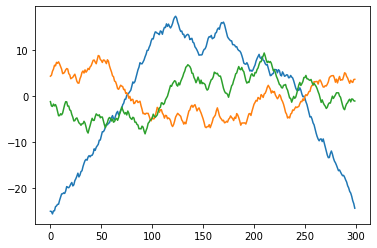

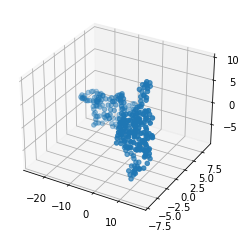

tensor([-1.2207e-04, -3.0518e-05,  8.0109e-05, -3.8147e-06, -9.5367e-07,
        -4.7684e-07])

In [5]:
# plot the first input data
fig, ax = plt.subplots()
ax.plot(dataset[0][0][:, 0])
ax.plot(dataset[0][0][:, 1])
ax.plot(dataset[0][0][:, 2])
plt.show()

# 3d scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset[0][0][:, 0], dataset[0][0][:, 1], dataset[0][0][:, 2])
plt.show()

torch.sum(dataset[0][0],dim=0)

In [ ]:
# check data length and bond length
for data, label in train_loader:
    # print(data.size(), label.size())
    # print(label[0:10])
    # print(data[0][0:10])

    # calculate the bond length
    key_length = torch.sqrt(torch.sum(data**2, dim=2))
    # output the max and min bond length
    print('max key length:', torch.max(key_length))
    print('min key length:', torch.min(key_length))


# 2. Define Model

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:,:x.size(1)]
        return x
    
class TransformerSequenceClassifier(nn.Module):
    def __init__(self, input_dim=3, d_model=512, nhead=8, num_encoder_layers=3, dim_feedforward=1024, num_classes=10, max_seq_len=500, dropout=0.2):
        super(TransformerSequenceClassifier, self).__init__()

        # vectorize input features, share weights
        self.feature_embedding = nn.Linear(input_dim, d_model)
        # add positional encoding
        self.position_encoder = PositionalEncoding(d_model, max_seq_len)

        self.layer_norm = nn.LayerNorm(d_model)
        # add CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        # transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        # classifier
        self.classifier = nn.Linear(d_model, num_classes)

        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        # add src mask
        src_mask = (src!=0).all(dim=2)

        # Embed input features to d_model dimensions 
        src = self.feature_embedding(src)
        # Add positional encoding
        src = self.position_encoder(src)

        src = self.layer_norm(src)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(src.size(0), -1, -1)
        src = torch.cat((cls_tokens, src), dim=1)

        # expand mask
        src_mask = torch.cat([torch.ones(src.size(0), 1).bool().to(src.device), src_mask], dim=1)

        # Pass through the transformer encoder
        src = self.transformer_encoder(src, src_key_padding_mask=~src_mask)

        src = self.dropout(src)

        # get the output of the CLS token
        output = src[:, 0]

        # Classify
        output = self.classifier(output)
        return output


## 2.1 Model sanity check

In [ ]:
# Model Test
batch_size = 32
seq_len = 100  # N，sequence length
input_dim = 3  # input dimension
d_model = 512  # attention hidden size
nhead = 8  # attention head number
num_encoder_layers = 3  # number of encoder layers
num_classes = 10  # number of classes

# create model
model = TransformerSequenceClassifier(input_dim, d_model, nhead, num_encoder_layers, num_classes)

# create hypothetical input
x = torch.randn(batch_size, seq_len, input_dim)

# forward pass
logits = model(x)
predictions = F.log_softmax(logits, dim=-1)

print(predictions.shape)  # should output: torch.Size([32, 10])
print(predictions)

## 2.2 Create model for knot classification problem

In [ ]:
# Create the model
model = TransformerSequenceClassifier(input_dim=3,d_model=128,nhead=8, num_classes=7,dim_feedforward=256)
print('Model Parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

# output shape and input shape
for data, label in train_loader:
    inputs = data
    print('Input:', inputs.size())
    output = model(inputs)
    print('Output:', output.size())
    break
    
# check model parameters mean and std
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.mean(), param.data.std())

        
# check accuracy
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# print('Train Accuracy:', accuracy(train_loader, model, device))

## 2.3 Roll out

In [4]:
def train_model(model, train_loader, epochs=20, lr=0.001, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss().to(device)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs//3, gamma=0.5)

    for epoch in (pbar1 :=tqdm(range(epochs), position = 1,leave=False, colour='green', ncols=80)):
        model.train()  # Set the model to training mode
        total_loss = 0
        for batch in (pbar2 :=tqdm(train_loader, position = 0,leave=True, colour='red', ncols=80)):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the correct device

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar2.set_description('EPOCH {}: Loss = {:.4f} at train step = {}'.format(epoch+1,loss.item(),pbar2.n))

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
        scheduler.step()
        # for name, param in model.named_parameters():
        #     if param.requires_grad:
        #         print(name, param.grad.abs().mean())

        # Compute the training accuracy
        train_acc = accuracy(train_loader, model, device)
        print(f'Training Accuracy: {train_acc:.4f}')
        # Compute the validation accuracy
        test_acc = accuracy(test_loader, model, device)
        print(f'Test Accuracy: {test_acc:.4f}')

        torch.save(model.state_dict(), f"transformer_model_epoch{epoch}_testacc{test_acc:.4f}.pth")

# Note: When calling train_model, ensure you have a model, a DataLoader (train_dl),
# and that your device is correctly configured (e.g., 'cuda' for GPU or 'cpu' for CPU).
    
# clear model
del model
# if model exists, load model
model = TransformerSequenceClassifier(input_dim=6,d_model=512,nhead=8, num_classes=8,dim_feedforward=128,num_encoder_layers=5,dropout=0.1,max_seq_len=1000)

if os.path.exists('transformer_model_epoch15_testacc0.9874.pth'):
    print('Loading model from checkpoint...')
    model.load_state_dict(torch.load('transformer_model_epoch15_testacc0.9874.pth'))
train_model(model, train_loader, epochs=10, lr=0.0001, device='cuda')

Loading model from checkpoint...


EPOCH 1: Loss = 0.0127 at train step = 13281: 100%|█| 13282/13282 [2:07:35<00:00

Epoch [1/10], Loss: 0.0920



/home/yongjian/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training Accuracy: 0.9786


Test Accuracy: 0.9760


EPOCH 2: Loss = 0.1345 at train step = 13281: 100%|█| 13282/13282 [2:07:39<00:00

Epoch [2/10], Loss: 0.0822


Training Accuracy: 0.9825


Test Accuracy: 0.9791


EPOCH 3: Loss = 0.0174 at train step = 13281: 100%|█| 13282/13282 [2:07:33<00:00

Epoch [3/10], Loss: 0.0739


Training Accuracy: 0.9846


Test Accuracy: 0.9806


EPOCH 4: Loss = 0.0027 at train step = 13281: 100%|█| 13282/13282 [2:07:30<00:00

Epoch [4/10], Loss: 0.0378


Training Accuracy: 0.9921


Test Accuracy: 0.9876


EPOCH 5: Loss = 0.1033 at train step = 13281: 100%|█| 13282/13282 [2:07:29<00:00

Epoch [5/10], Loss: 0.0318


Training Accuracy: 0.9934


Test Accuracy: 0.9886


EPOCH 6: Loss = 0.0050 at train step = 13281: 100%|█| 13282/13282 [2:07:29<00:00

Epoch [6/10], Loss: 0.0284


Training Accuracy: 0.9947


Test Accuracy: 0.9902


EPOCH 7: Loss = 0.0121 at train step = 13281: 100%|█| 13282/13282 [2:07:29<00:00

Epoch [7/10], Loss: 0.0141


Training Accuracy: 0.9982


Test Accuracy: 0.9938


EPOCH 8: Loss = 0.0005 at train step = 13281: 100%|█| 13282/13282 [2:07:34<00:00

Epoch [8/10], Loss: 0.0111


Training Accuracy: 0.9984


Test Accuracy: 0.9939


EPOCH 9: Loss = 0.0045 at train step = 449:   3%| | 450/13282 [04:21<2:04:20,  1


KeyboardInterrupt: 

In [ ]:
# save model, name the model with the accuracy and dates
torch.save(model.state_dict(), 'transformer_model_acc0.9994{}.pth'.format(time.strftime('%Y%m%d_%H%M%S')))